# Assignment 9: GBDT

#### Response Coding: Example

<img src='http://i.imgur.com/TufZptV.jpg' width=700px>

> The response tabel is built only on train dataset.
> For a category which is not there in train data and present in test data, we will encode them with default values
Ex: in our test data if have State: D then we encode it as [0.5, 0.05]

<ol>
    <li><strong>Apply GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>Set 1</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF)+  preprocessed_eassay (TFIDF)+sentiment Score of eassay(check the bellow example, include all 4 values as 4 features)</li>
            <li><font color='red'>Set 2</font>: categorical(instead of one hot encoding, try <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/'>response coding</a>: use probability values), numerical features + project_title(TFIDF W2V)+  preprocessed_eassay (TFIDF W2V)</li>        
    </li>
    <li> Here in response encoding you need to apply the <strong>laplase smoothing</strong> value for test set. Laplase smoothing means, If test point is present in test but not in train then you need to apply default 0.5 as probability value for that data point (Refer the Response Encoding Image from above cell) </li>
    <li>Please use atleast <strong> 35k </strong> data points </li></ul>
    <li><strong>The hyper paramter tuning (Consider any two hyper parameters)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>find the best hyper paramter using k-fold cross validation/simple cross validation data</li>
    <li>use gridsearch cv or randomsearch cv or you can write your own for loops to do this task</li>
        </ul>
    </li>
    <li>
    <strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/Gp2DQmh.jpg' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>or</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/fgN9aUP.jpg' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
        Make sure that you are using predict_proba method to calculate AUC curves, because AUC is calcualted on class probabilities and not on class labels.
    <img src='https://i.imgur.com/wMQDTFe.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
    <img src='https://i.imgur.com/IdN5Ctv.png' width=300px></li>
            </ul>
    <br>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

# Few Notes

1. Use atleast 35k data points
2. Use classifier.Predict_proba() method instead of predict() method while calculating roc_auc scores
3. Be sure that you are using laplase smoothing in response encoding function. Laplase smoothing means applying the default (0.5) value to test data if the test data is not present in the train set


In [1]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# import nltk
# nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()

sample_sentence_1='I am happy.'
ss_1 = sid.polarity_scores(sample_sentence_1)
print('sentiment score for sentence 1',ss_1)

sample_sentence_2='I am sad.'
ss_2 = sid.polarity_scores(sample_sentence_2)
print('sentiment score for sentence 2',ss_2)

sample_sentence_3='I am going to New Delhi tommorow.'
ss_3 = sid.polarity_scores(sample_sentence_3)
print('sentiment score for sentence 3',ss_3)


sentiment score for sentence 1 {'neg': 0.0, 'neu': 0.213, 'pos': 0.787, 'compound': 0.5719}
sentiment score for sentence 2 {'neg': 0.756, 'neu': 0.244, 'pos': 0.0, 'compound': -0.4767}
sentiment score for sentence 3 {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


<h1>1. GBDT (xgboost/lightgbm) </h1>

## 1.1 Loading Data

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix
from scipy.sparse import hstack
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import GradientBoostingClassifier

data = pd.read_csv('cleaned_donors_choose_data.csv')

In [3]:
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [4]:
def sentiment_values(dict_values):
    return dict_values["neg"], dict_values["neu"], dict_values["pos"], dict_values["compound"]

In [5]:
negative = []
neutral = []
positive = []
compound = []
# Computing sentiment values and storing them in list
for essay in tqdm(data["essay"]):
    ss = sid.polarity_scores(essay)
    neg, neu , pos, comp = ss["neg"], ss["neu"], ss["pos"], ss["compound"]
    negative.append(neg)
    neutral.append(neu)
    positive.append(pos)
    compound.append(comp)

100%|█████████████████████████████████████████████████████████████████████████| 109248/109248 [02:33<00:00, 712.40it/s]


In [6]:
#Creating new columns in our dataset with sentiment values
data["negative"] = negative
data["neutral"] = neutral
data["positive"] = positive
data["compound"] = compound

In [7]:
data.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'clean_titles', 'essay',
       'price', 'negative', 'neutral', 'positive', 'compound'],
      dtype='object')

In [8]:
data.head(1)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,clean_titles,essay,price,negative,neutral,positive,compound
0,in,mrs,grades_prek_2,0,0,literacy_language,esl_literacy,educational support english learners home,students english learners working english seco...,154.6,0.013,0.833,0.154,0.9694


In [9]:
y = data['project_is_approved'].values
X = data.drop(['project_is_approved'], axis=1)

<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [10]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=0)

<h2>1.3 Make Data Model Ready: encoding essay, and project_title</h2>

### 1.3.1 Essay - TFIDF Representation

In [11]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

essay_vectorizer_tfidf = TfidfVectorizer(min_df=10, max_features=5000)
essay_vectorizer_tfidf.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_essay_tfidf = essay_vectorizer_tfidf.transform(X_train['essay'].values)
X_test_essay_tfidf = essay_vectorizer_tfidf.transform(X_test['essay'].values)

print("After vectorizations")
print(X_train_essay_tfidf.shape, y_train.shape)
print(X_test_essay_tfidf.shape, y_test.shape)
print("="*100)

(73196, 13) (73196,)
(36052, 13) (36052,)
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


<h3> 1.3.2 Essay - TFIDF Word2Vec Representation

In [12]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["essay"])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [13]:
#Train data
X_train_essay_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_essay_tfidf_w2v_vectors.append(vector)

print(len(X_train_essay_tfidf_w2v_vectors))
print(len(X_train_essay_tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 73196/73196 [01:49<00:00, 666.91it/s]

73196
300


In [14]:
#Test Data
X_test_essay_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["essay"]): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_essay_tfidf_w2v_vectors.append(vector)

print(len(X_test_essay_tfidf_w2v_vectors))
print(len(X_test_essay_tfidf_w2v_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 36052/36052 [00:51<00:00, 698.82it/s]

36052
300


### 1.3.3 Project Title - Tfidf Representation

In [15]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)

title_vectorizer_tfidf = TfidfVectorizer(min_df=10, max_features=5000)
title_vectorizer_tfidf.fit(X_train['clean_titles'].values.astype('U')) # Making the titles to be treated as Unicode String as 
                                                                       # some titles are blank after pre-processing

# we use the fitted TfidfVectorizer to convert the text to vector
X_train_title_tfidf = essay_vectorizer_tfidf.transform(X_train['clean_titles'].values.astype('U'))
X_test_title_tfidf = essay_vectorizer_tfidf.transform(X_test['clean_titles'].values.astype('U'))

print("After vectorizations")
print(X_train_title_tfidf.shape, y_train.shape)
print(X_test_title_tfidf.shape, y_test.shape)
print("="*100)

(73196, 13) (73196,)
(36052, 13) (36052,)
After vectorizations
(73196, 5000) (73196,)
(36052, 5000) (36052,)


### 1.3.4 Project Title - Tfidf Word2Vec Representation

In [16]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(X_train["clean_titles"].values.astype('U'))
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [17]:
#Train data
X_train_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_train["clean_titles"].values.astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_train_titles_tfidf_w2v_vectors.append(vector)

print(len(X_train_titles_tfidf_w2v_vectors))
print(len(X_train_titles_tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 73196/73196 [00:01<00:00, 42971.10it/s]

73196
300


In [18]:
#Test Data
X_test_titles_tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X_test["clean_titles"].values.astype('U')): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    X_test_titles_tfidf_w2v_vectors.append(vector)

print(len(X_test_titles_tfidf_w2v_vectors))
print(len(X_test_titles_tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 36052/36052 [00:00<00:00, 43114.73it/s]

36052
300


<h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

In [19]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding 
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# make sure you featurize train and test data separatly

# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 1.4.1 Categorical features

### Response Encoding

In [20]:
train = X_train.copy()   # x_train and y_train are put in a single dataframe as they are both needed for response encoding 
train['project_approval'] = y_train  

In [21]:
def response_encoding(x,feature):
    count = train[feature].value_counts()   # Using only train data for calculating probabilities
    probabilities  = dict()
    for i, total in count.items():
        num_0 = len(train.loc[(train[feature]==i) & (train['project_approval'] == 0)])
        num_1 = len(train.loc[(train[feature]==i) & (train['project_approval'] == 1)])
        probabilities[i] = [num_0/total, num_1/total]
    rc = []
    for category in x[feature]:
        if category in probabilities.keys():
            rc.append(probabilities[category])
        else:
            rc.append([0.5,0.5])
    return np.array(rc)

<h3>1.4.1.1 encoding categorical features: School State</h3>

In [22]:
X_train_state_rc =response_encoding(X_train, 'school_state')
X_test_state_rc =response_encoding(X_test, 'school_state')
print("After vectorizations")
print(X_train_state_rc.shape, y_train.shape)
print(X_test_state_rc.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


<h3>1.4.1.2 encoding categorical features: teacher_prefix</h3>

In [23]:
X_train_teacher_rc =response_encoding(X_train, 'teacher_prefix')
X_test_teacher_rc =response_encoding(X_test, 'teacher_prefix')
print("After vectorizations")
print(X_train_teacher_rc.shape, y_train.shape)
print(X_test_teacher_rc.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


<h3>1.4.1.3 encoding categorical features: project_grade_category</h3>

In [24]:
X_train_grade_rc =response_encoding(X_train, 'project_grade_category')
X_test_grade_rc =response_encoding(X_test, 'project_grade_category')
print("After vectorizations")
print(X_train_grade_rc.shape, y_train.shape)
print(X_test_grade_rc.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


<h3>1.4.1.4 encoding categorical features: clean_categories</h3>

In [25]:
X_train_categories_rc =response_encoding(X_train, 'clean_categories')
X_test_categories_rc =response_encoding(X_test, 'clean_categories')
print("After vectorizations")
print(X_train_categories_rc.shape, y_train.shape)
print(X_test_categories_rc.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


<h3>1.4.1.5 encoding categorical features: clean_subcategories</h3>

In [26]:
X_train_subcategories_rc =response_encoding(X_train, 'clean_subcategories')
X_test_subcategories_rc =response_encoding(X_test, 'clean_subcategories')
print("After vectorizations")
print(X_train_subcategories_rc.shape, y_train.shape)
print(X_test_subcategories_rc.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 2) (73196,)
(36052, 2) (36052,)


## 1.4.2 Numerical Features

<h3>1.4.2.1 encoding numerical features: Price</h3>

In [27]:
# Decision Trees do not need feature Standardization or normalization


#Reshaping so that the number of rows of the features is same for all data
X_train_price=X_train["price"].values.reshape(-1,1)
X_test_price=X_test["price"].values.reshape(-1,1)

print("After vectorizations")
print(X_train_price.shape, y_train.shape)
print(X_test_price.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h3>1.4.2.2 encoding numerical features: teacher_number_of_previously_posted_projects</h3>

In [28]:
# Decision Trees do not need feature Standardization or normalization

#Reshaping so that the number of rows of the features is same for all data
X_train_teacher_num_previous_projects=X_train['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

X_test_teacher_num_previous_projects=X_test['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_teacher_num_previous_projects.shape, y_train.shape)
print(X_test_teacher_num_previous_projects.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h3>1.4.2.3 encoding numerical features: negative</h3>

In [29]:
# Decision Trees do not need feature Standardization or normalization
X_train_negative=X_train['negative'].values.reshape(-1,1)
X_test_negative=X_test['negative'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_negative.shape, y_train.shape)
print(X_test_negative.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h3>1.4.2.4 encoding numerical features: neutral</h3>

In [30]:
# Decision Trees do not need feature Standardization or normalization
X_train_neutral=X_train['neutral'].values.reshape(-1,1)
X_test_neutral=X_test['neutral'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_neutral.shape, y_train.shape)
print(X_test_neutral.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h3>1.4.2.5 encoding numerical features: positive</h3>

In [31]:
# Decision Trees do not need feature Standardization or normalization
X_train_positive=X_train['positive'].values.reshape(-1,1)
X_test_positive=X_test['positive'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_positive.shape, y_train.shape)
print(X_test_positive.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


<h3>1.4.2.6 encoding numerical features: compound</h3>

In [32]:
# Decision Trees do not need feature Standardization or normalization
X_train_compound=X_train['compound'].values.reshape(-1,1)
X_test_compound=X_test['compound'].values.reshape(-1,1)

print("After vectorizations")
print(X_train_compound.shape, y_train.shape)
print(X_test_compound.shape, y_test.shape)
print("="*100)

After vectorizations
(73196, 1) (73196,)
(36052, 1) (36052,)


### 1.4.3 Concatinating all the features

### Set - 1

In [33]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
X_train_set_one = hstack((X_train_essay_tfidf, X_train_title_tfidf, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_categories_rc, X_train_subcategories_rc, X_train_price, X_train_teacher_num_previous_projects, X_train_negative, X_train_neutral, X_train_positive, X_train_compound)).tocsr()
X_test_set_one = hstack((X_test_essay_tfidf, X_test_title_tfidf,  X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_categories_rc, X_test_subcategories_rc, X_test_price , X_test_teacher_num_previous_projects, X_test_negative, X_test_neutral, X_test_positive, X_test_compound)).tocsr()

print("Final Data matrix - TFIDF:")
print(X_train_set_one.shape, y_train.shape)
print(X_test_set_one.shape, y_test.shape)
print("="*100)

Final Data matrix - TFIDF:
(73196, 10016) (73196,)
(36052, 10016) (36052,)


### Set - 2

In [34]:
# This set does not have sparse matrices
X_train_set_two = np.hstack((X_train_essay_tfidf_w2v_vectors, X_train_titles_tfidf_w2v_vectors, X_train_state_rc, X_train_teacher_rc, X_train_grade_rc, X_train_categories_rc, X_train_subcategories_rc, X_train_price, X_train_teacher_num_previous_projects, X_train_negative, X_train_neutral, X_train_positive, X_train_compound))
X_test_set_two = np.hstack((X_test_essay_tfidf_w2v_vectors, X_test_titles_tfidf_w2v_vectors,  X_test_state_rc, X_test_teacher_rc, X_test_grade_rc, X_test_categories_rc, X_test_subcategories_rc, X_test_price , X_test_teacher_num_previous_projects, X_test_negative, X_test_neutral, X_test_positive, X_test_compound))

print("Final Data matrix - TFIDF W2V:")
print(X_train_set_two.shape, y_train.shape)
print(X_test_set_two.shape, y_test.shape)
print("="*100)

Final Data matrix - TFIDF W2V:
(73196, 616) (73196,)
(36052, 616) (36052,)


<h2>1.5 Appling Models on different kind of featurization as mentioned in the instructions</h2>

<br>Apply GBDT on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [35]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

### 1.5.1 Set 1:

### 1.5.1.1 Apply GBDT on Dataset

In [36]:
%%time
GBDT_parameters = {'max_depth':[1,2,3,4],'n_estimators':[5,10,15,20]}     #max_depth should be small for GBDT
clf = GridSearchCV(GradientBoostingClassifier(random_state=0), GBDT_parameters, scoring = 'roc_auc', cv = 5, return_train_score = True, n_jobs = -1)
clf.fit(X_train_set_one,y_train)

Wall time: 6min 9s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=0),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [37]:
train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

In [41]:
print("Best score= ",clf.best_score_)
print("Best Hyper parameters = ",clf.best_params_)

Best score=  0.6843711728431356
Best Hyper parameters =  {'max_depth': 4, 'n_estimators': 20}


### 1.5.1.2 Hyperparameter vs AUC Plot

<AxesSubplot:title={'center':'CV Dataset'}, xlabel='param_max_depth', ylabel='param_n_estimators'>

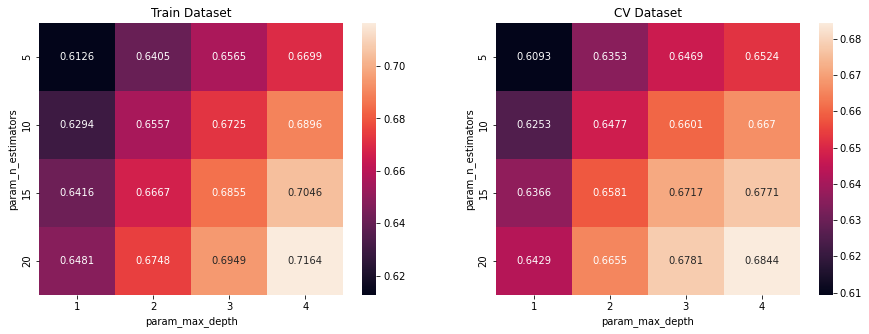

In [42]:
#Below code is obtained from: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Train Dataset")
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.subplot(1,2,2)
plt.title("CV Dataset")
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')

### 1.5.1.3 Plot ROC-AUC curve of model with best hyperparameters

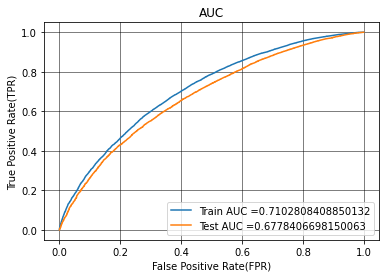

In [43]:
GBDT_set_one=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"],n_estimators = clf.best_params_["n_estimators"], random_state=0)
GBDT_set_one.fit(X_train_set_one,y_train)

y_train_proba = GBDT_set_one.predict_proba(X_train_set_one)[:,1]
y_test_proba = GBDT_set_one.predict_proba(X_test_set_one)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_proba)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_proba)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### 1.5.1.4 Confusion Matrix for Train and Test data

In [44]:
def find_best_threshold(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of fpr*(1-tpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [45]:
def predict_with_best_threshold(proba, t):    
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [46]:
print("="*100)

best_threshold = find_best_threshold(y_train_proba, tr_thresholds, train_fpr, train_tpr)
conf_matr_train_set_one = confusion_matrix(y_train, predict_with_best_threshold(y_train_proba, best_threshold))
print("Train confusion matrix")
print(conf_matr_train_set_one)

the maximum value of fpr*(1-tpr) 0.42520404598454176 for threshold 0.846
Train confusion matrix
[[ 7039  4044]
 [20529 41584]]


Text(26.5, 0.5, 'True class')

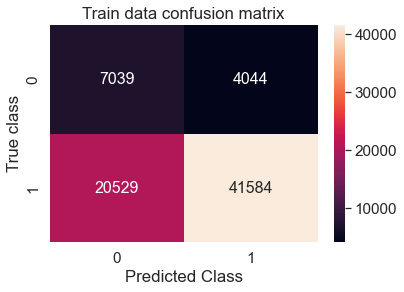

In [47]:
sns.set(font_scale=1.4)#for label size

sns.heatmap(conf_matr_train_set_one, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title("Train data confusion matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True class")

In [48]:
print("="*100)
print("Test confusion matrix")
conf_matr_test_set_one = confusion_matrix(y_test, predict_with_best_threshold(y_test_proba, best_threshold))
print(conf_matr_test_set_one)

Test confusion matrix
[[ 3235  2224]
 [10308 20285]]


Text(26.5, 0.5, 'True class')

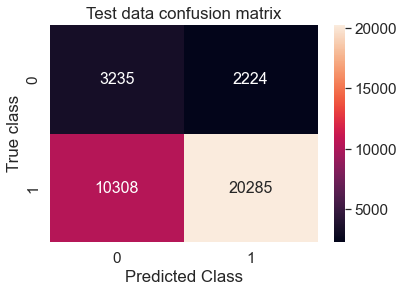

In [49]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_test_set_one, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title("Test data confusion matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True class")

### 1.5.2 Set 2:

### 1.5.2.1 Apply GBDT on Dataset

In [59]:
GBDT_parameters = {'max_depth':[1,2,3,4],'n_estimators':[5,10,15,20]}
clf = GridSearchCV(GradientBoostingClassifier(random_state=0, verbose = 1), GBDT_parameters, scoring = 'roc_auc', cv = 5, return_train_score = True, n_jobs = -1)
clf.fit(X_train_set_two,y_train)

      Iter       Train Loss   Remaining Time 
         1           0.8435            6.78m
         2           0.8378            6.44m
         3           0.8326            6.07m
         4           0.8279            5.71m
         5           0.8237            5.36m
         6           0.8196            5.01m
         7           0.8160            4.65m
         8           0.8125            4.29m
         9           0.8093            3.94m
        10           0.8063            3.58m
        20           0.7841            0.00s


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(random_state=0, verbose=1),
             n_jobs=-1,
             param_grid={'max_depth': [1, 2, 3, 4],
                         'n_estimators': [5, 10, 15, 20]},
             return_train_score=True, scoring='roc_auc')

In [60]:
train_auc = clf.cv_results_['mean_train_score']
cv_auc = clf.cv_results_['mean_test_score']

In [61]:
print("Best score= ",clf.best_score_)
print("Best Hyper parameters = ",clf.best_params_)

Best score=  0.6927180923216303
Best Hyper parameters =  {'max_depth': 4, 'n_estimators': 20}


### 1.5.1.2 Hyperparameter vs AUC Plot

<AxesSubplot:title={'center':'CV Dataset'}, xlabel='param_max_depth', ylabel='param_n_estimators'>

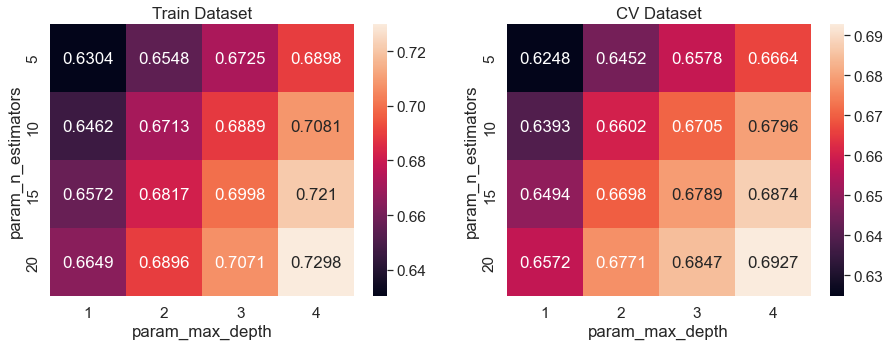

In [62]:
#Below code is obtained from: https://towardsdatascience.com/using-3d-visualizations-to-tune-hyperparameters-of-ml-models-with-python-ba2885eab2e9
max_scores = pd.DataFrame(clf.cv_results_).groupby(['param_n_estimators', 'param_max_depth']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.title("Train Dataset")
sns.heatmap(max_scores.mean_train_score, annot=True, fmt='.4g')
plt.subplot(1,2,2)
plt.title("CV Dataset")
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')

### 1.5.1.3 Plot ROC-AUC curve of model with best hyperparameters

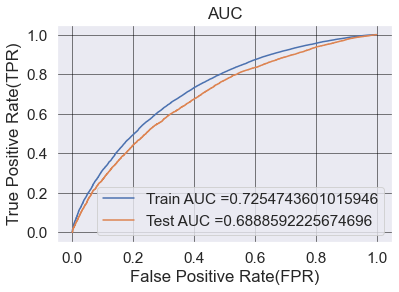

In [79]:
GBDT_set_two=GradientBoostingClassifier(max_depth = clf.best_params_["max_depth"],n_estimators = clf.best_params_["n_estimators"], random_state=0)
GBDT_set_two.fit(X_train_set_two,y_train)

y_train_proba = GBDT_set_two.predict_proba(X_train_set_two)[:,1]
y_test_proba = GBDT_set_two.predict_proba(X_test_set_two)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_proba)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_proba)

plt.plot(train_fpr, train_tpr, label="Train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="Test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("False Positive Rate(FPR)")
plt.ylabel("True Positive Rate(TPR)")
plt.title("AUC")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

### 1.5.1.4 Confusion Matrix for Train and Test data

In [80]:
def find_best_threshold(proba, threshould, fpr, tpr):
    
    t = threshould[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of fpr*(1-tpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

In [81]:
def predict_with_best_threshold(proba, t):    
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [82]:
print("="*100)

best_threshold = find_best_threshold(y_train_proba, tr_thresholds, train_fpr, train_tpr)
conf_matr_train_set_two = confusion_matrix(y_train, predict_with_best_threshold(y_train_proba, best_threshold))
print("Train confusion matrix")
print(conf_matr_train_set_two)

the maximum value of fpr*(1-tpr) 0.44411710039776253 for threshold 0.847
Train confusion matrix
[[ 7459  3624]
 [21125 40988]]


Text(26.5, 0.5, 'True class')

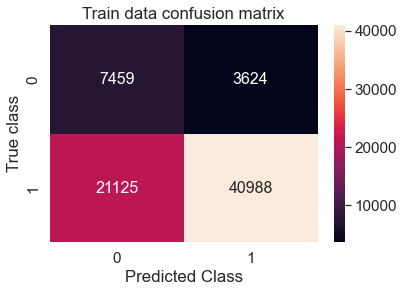

In [83]:
sns.set(font_scale=1.4)#for label size

sns.heatmap(conf_matr_train_set_two, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title("Train data confusion matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True class")

In [84]:
print("="*100)
print("Test confusion matrix")
conf_matr_test_set_two = confusion_matrix(y_test, predict_with_best_threshold(y_test_proba, best_threshold))
print(conf_matr_test_set_two)

Test confusion matrix
[[ 3411  2048]
 [10712 19881]]


Text(26.5, 0.5, 'True class')

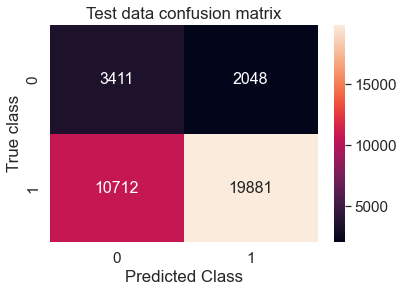

In [85]:
sns.set(font_scale=1.4)#for label size
sns.heatmap(conf_matr_test_set_two, annot=True,annot_kws={"size": 16}, fmt='g')
plt.title("Test data confusion matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True class")

<h1>3. Summary</h1>

<br> as mentioned in the step 4 of instructions

In [88]:
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Vectorizer", "Model", "Hyper Parameter", "AUC"]

x.add_row(["TFIDF", "Decision Tree","max_depth = 4, n_estimators = 20", "0.6778"])
x.add_row(["TFIDF W2V", "Decision Tree", "max_depth = 4, n_estimators = 20", "0.6888"])

print(x)

+------------+---------------+----------------------------------+--------+
| Vectorizer |     Model     |         Hyper Parameter          |  AUC   |
+------------+---------------+----------------------------------+--------+
|   TFIDF    | Decision Tree | max_depth = 4, n_estimators = 20 | 0.6778 |
| TFIDF W2V  | Decision Tree | max_depth = 4, n_estimators = 20 | 0.6888 |
+------------+---------------+----------------------------------+--------+
